In [98]:
from qiskit.transpiler.coupling import CouplingMap
from mirror_gates.pass_managers import Mirage, QiskitLevel3
from transpile_benchy.metrics.gate_counts import (
    DepthMetric,
    TotalMetric,
    TotalSwaps,
)
from qiskit.transpiler import PassManager
import numpy as np
from mirror_gates.logging import transpile_benchy_logger
from mirror_gates.sqiswap_decomposer import SiSwapDecomposePass
from qiskit.transpiler.passmanager import PassManager
from qiskit import Aer, transpile
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    pauli_error,
    depolarizing_error,
    thermal_relaxation_error,
    RelaxationNoisePass,
)
from qiskit.circuit import Delay

In [99]:
N = 8
# coupling_map = FakeQuitoV2().target.build_coupling_map()
# coupling_map = CouplingMap.from_grid(4,4)
coupling_map = CouplingMap.from_line(N)
# coupling_map = CouplingMap.from_heavy_hex(5)
# coupling_map.draw()

Loading qft_n4 from QASMBench


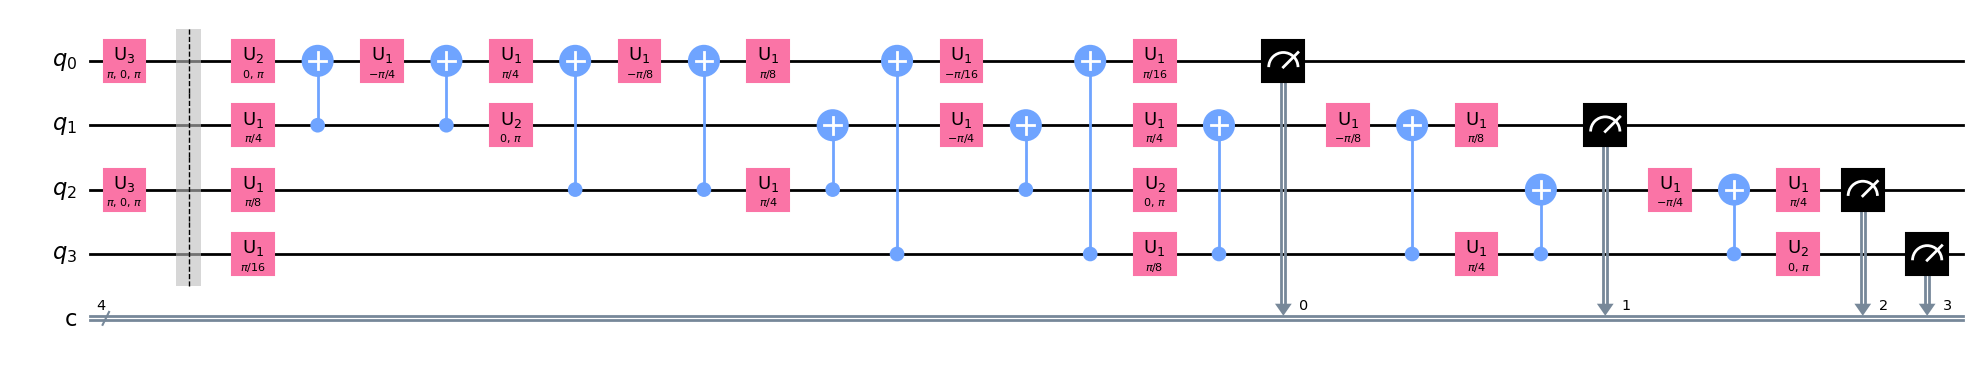

In [100]:
# from transpile_benchy.interfaces.mqt_interface import MQTBench
from transpile_benchy.interfaces.qasm_interface import QASMBench
from transpile_benchy.library import CircuitLibrary

lib = CircuitLibrary(circuit_list=[])
qc = lib.get_circuit("qft_n4")
qc = qc.decompose()
display(qc.draw("mpl", fold=-1))

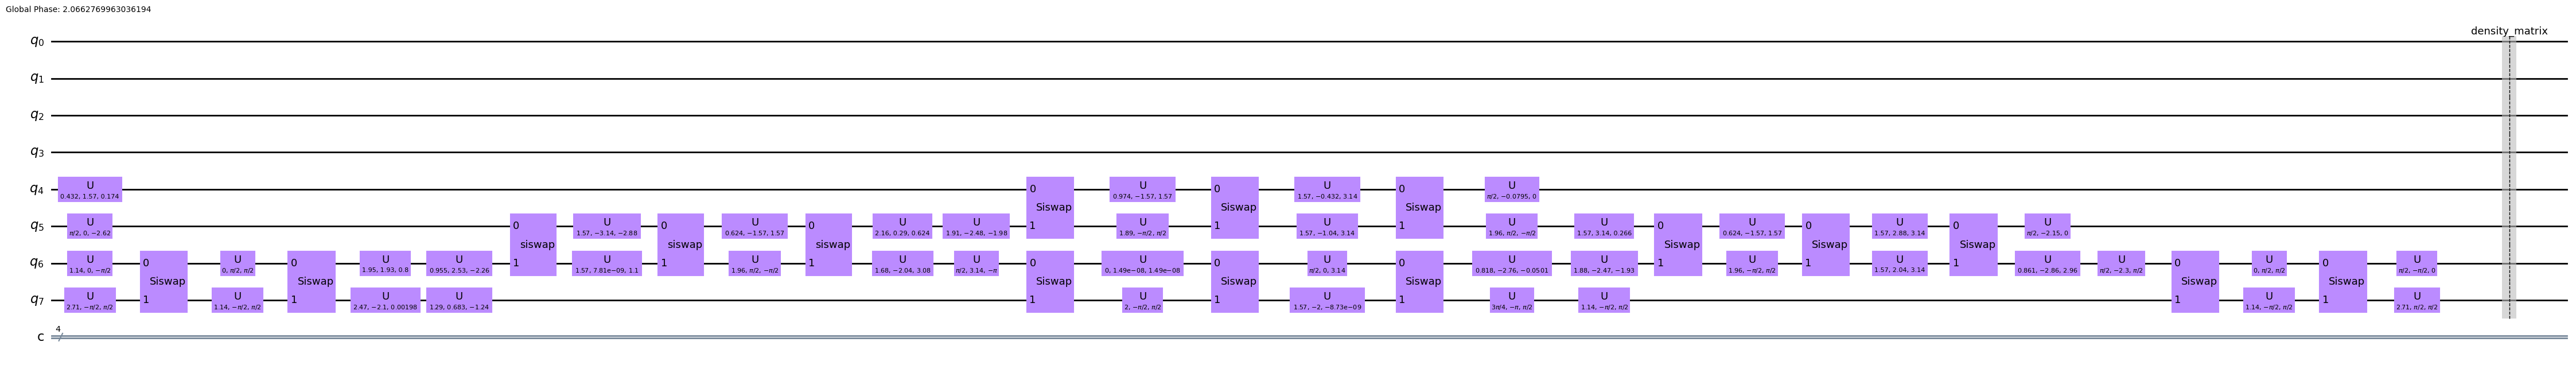

In [101]:
runner = Mirage(
    coupling_map,
    cx_basis=0,
    parallel=0,
    logger=transpile_benchy_logger,
    cost_function="depth",
    # cost_function="basic",
    anneal_routing=True,
    layout_trials=20,
    fb_iters=4,
    # layout_trials=20,
    # fb_iters=4,
    # fixed_aggression=0
    # cost_function="basic",
    use_fast_settings=1,
)

routed = runner.run(qc)
decomposer = PassManager()
decomposer.append(SiSwapDecomposePass())
mirage_output = decomposer.run(routed)
mirage_output.save_density_matrix()
mirage_output.draw("mpl", fold=-1)

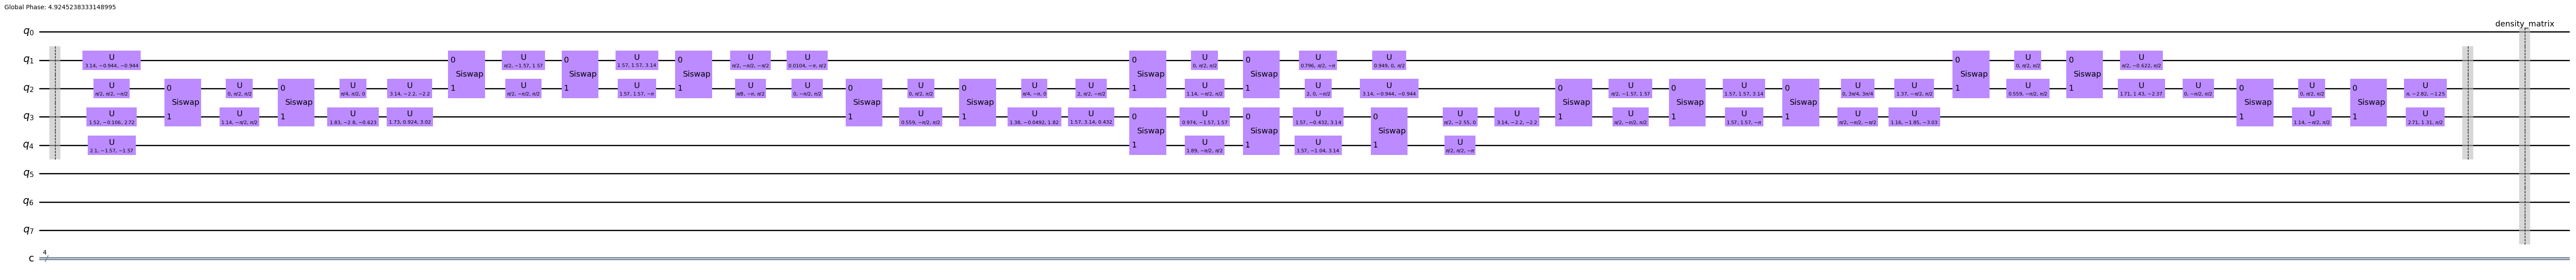

In [102]:
runner = QiskitLevel3(coupling_map, cx_basis=0)
routed = runner.run(qc)
decomposer = PassManager()
decomposer.append(SiSwapDecomposePass())
qiskit_output = decomposer.run(routed)
qiskit_output.save_density_matrix()
qiskit_output.draw("mpl", fold=-1)

In [103]:
# qc = mirage_output
qc = qiskit_output
simulator = Aer.get_backend("aer_simulator")
circ = transpile(qc, simulator, basis_gates=["rxx", "ryy", "u", "save_density_matrix"])

In [104]:
# T1 and T2 values for all qubits
N = coupling_map.size()

np.random.seed(42)
# Sampled from normal distribution mean 100 microsec
T1s = np.random.normal(100e3, 10e3, N)
# Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(50e3, 10e3, N)

# Instruction times (in nanoseconds)
time_u3 = 25  # (two X90 pulses)
time_cx = 100
time_siswap = time_cx / 2.0
# divide by 2 again since each sqrt(iSwap) is compiled to RXX and RYY
time_rxx = time_siswap / 2.0

# (inst, qubits, time)
instruction_durations = []

errors_u3 = [thermal_relaxation_error(t1, t2, time_u3) for t1, t2 in zip(T1s, T2s)]
errors_cx = [
    [
        thermal_relaxation_error(t1a, t2a, time_cx).expand(
            thermal_relaxation_error(t1b, t2b, time_cx)
        )
        for t1a, t2a in zip(T1s, T2s)
    ]
    for t1b, t2b in zip(T1s, T2s)
]

errors_rxx = [
    [
        thermal_relaxation_error(t1a, t2a, time_rxx).expand(
            thermal_relaxation_error(t1b, t2b, time_rxx)
        )
        for t1a, t2a in zip(T1s, T2s)
    ]
    for t1b, t2b in zip(T1s, T2s)
]

# Add errors to noise model
noise_thermal = NoiseModel(basis_gates=["u", "rxx", "ryy"])
for j in range(N):
    noise_thermal.add_quantum_error(errors_u3[j], "u", [j])
    instruction_durations.append(("u", j, time_u3))

for j, k in coupling_map:
    noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
    noise_thermal.add_quantum_error(errors_rxx[j][k], "rxx", [j, k])
    noise_thermal.add_quantum_error(errors_rxx[j][k], "ryy", [j, k])
    instruction_durations.append(("cx", (j, k), time_cx))
    instruction_durations.append(("rxx", (j, k), time_rxx))
    instruction_durations.append(("ryy", (j, k), time_rxx))

print(noise_thermal)

instruction_durations.append(("save_density_matrix", [0, 1, 2, 3, 4, 5, 6, 7], 0.0))
noisy_simulator = AerSimulator(noise_model=noise_thermal)
noisy_circ = transpile(qc, noisy_simulator)

NoiseModel:
  Basis gates: ['cx', 'rxx', 'ryy', 'u']
  Instructions with noise: ['rxx', 'cx', 'ryy', 'u']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7]
  Specific qubit errors: [('u', (0,)), ('u', (1,)), ('u', (2,)), ('u', (3,)), ('u', (4,)), ('u', (5,)), ('u', (6,)), ('u', (7,)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (2, 3)), ('cx', (3, 2)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (4, 5)), ('cx', (5, 4)), ('cx', (5, 6)), ('cx', (6, 5)), ('cx', (6, 7)), ('cx', (7, 6)), ('rxx', (0, 1)), ('rxx', (1, 0)), ('rxx', (1, 2)), ('rxx', (2, 1)), ('rxx', (2, 3)), ('rxx', (3, 2)), ('rxx', (3, 4)), ('rxx', (4, 3)), ('rxx', (4, 5)), ('rxx', (5, 4)), ('rxx', (5, 6)), ('rxx', (6, 5)), ('rxx', (6, 7)), ('rxx', (7, 6)), ('ryy', (0, 1)), ('ryy', (1, 0)), ('ryy', (1, 2)), ('ryy', (2, 1)), ('ryy', (2, 3)), ('ryy', (3, 2)), ('ryy', (3, 4)), ('ryy', (4, 3)), ('ryy', (4, 5)), ('ryy', (5, 4)), ('ryy', (5, 6)), ('ryy', (6, 5)), ('ryy', (6, 7)), ('ryy', (7, 6))]


In [105]:
circ = transpile(
    circ, instruction_durations=instruction_durations, scheduling_method="asap"
)

In [106]:
from qiskit.transpiler.basepasses import TransformationPass


class PadIdentities(TransformationPass):
    def run(self, dag):
        # get all qubits
        qubits = set(dag.qubits)

        for layer in list(dag.layers())[:2]:
            # get active qubits
            active = set(layer["partition"])

            # active looks like (q1, q2)
            # or for 1Q gate (q1, )
            # but qubits is q1
            # so we need to flatten tuples
            active = set([q for q in active for q in q])

            # get inactive qubits
            inactive = qubits - active

            print(inactive)

            # inactive qubits, add identity at this layer
            for q in inactive:
                dag.apply


from qiskit.transpiler.passes import PadDelay, ASAPSchedule

pm = PassManager()
pm.append(ASAPSchedule())
# pm.append(PadDelay())
pm.append(RelaxationNoisePass([100e-6] * 8, [50e-6] * 8, dt=1e-9, op_types=[Delay]))
circ = pm.run(circ)

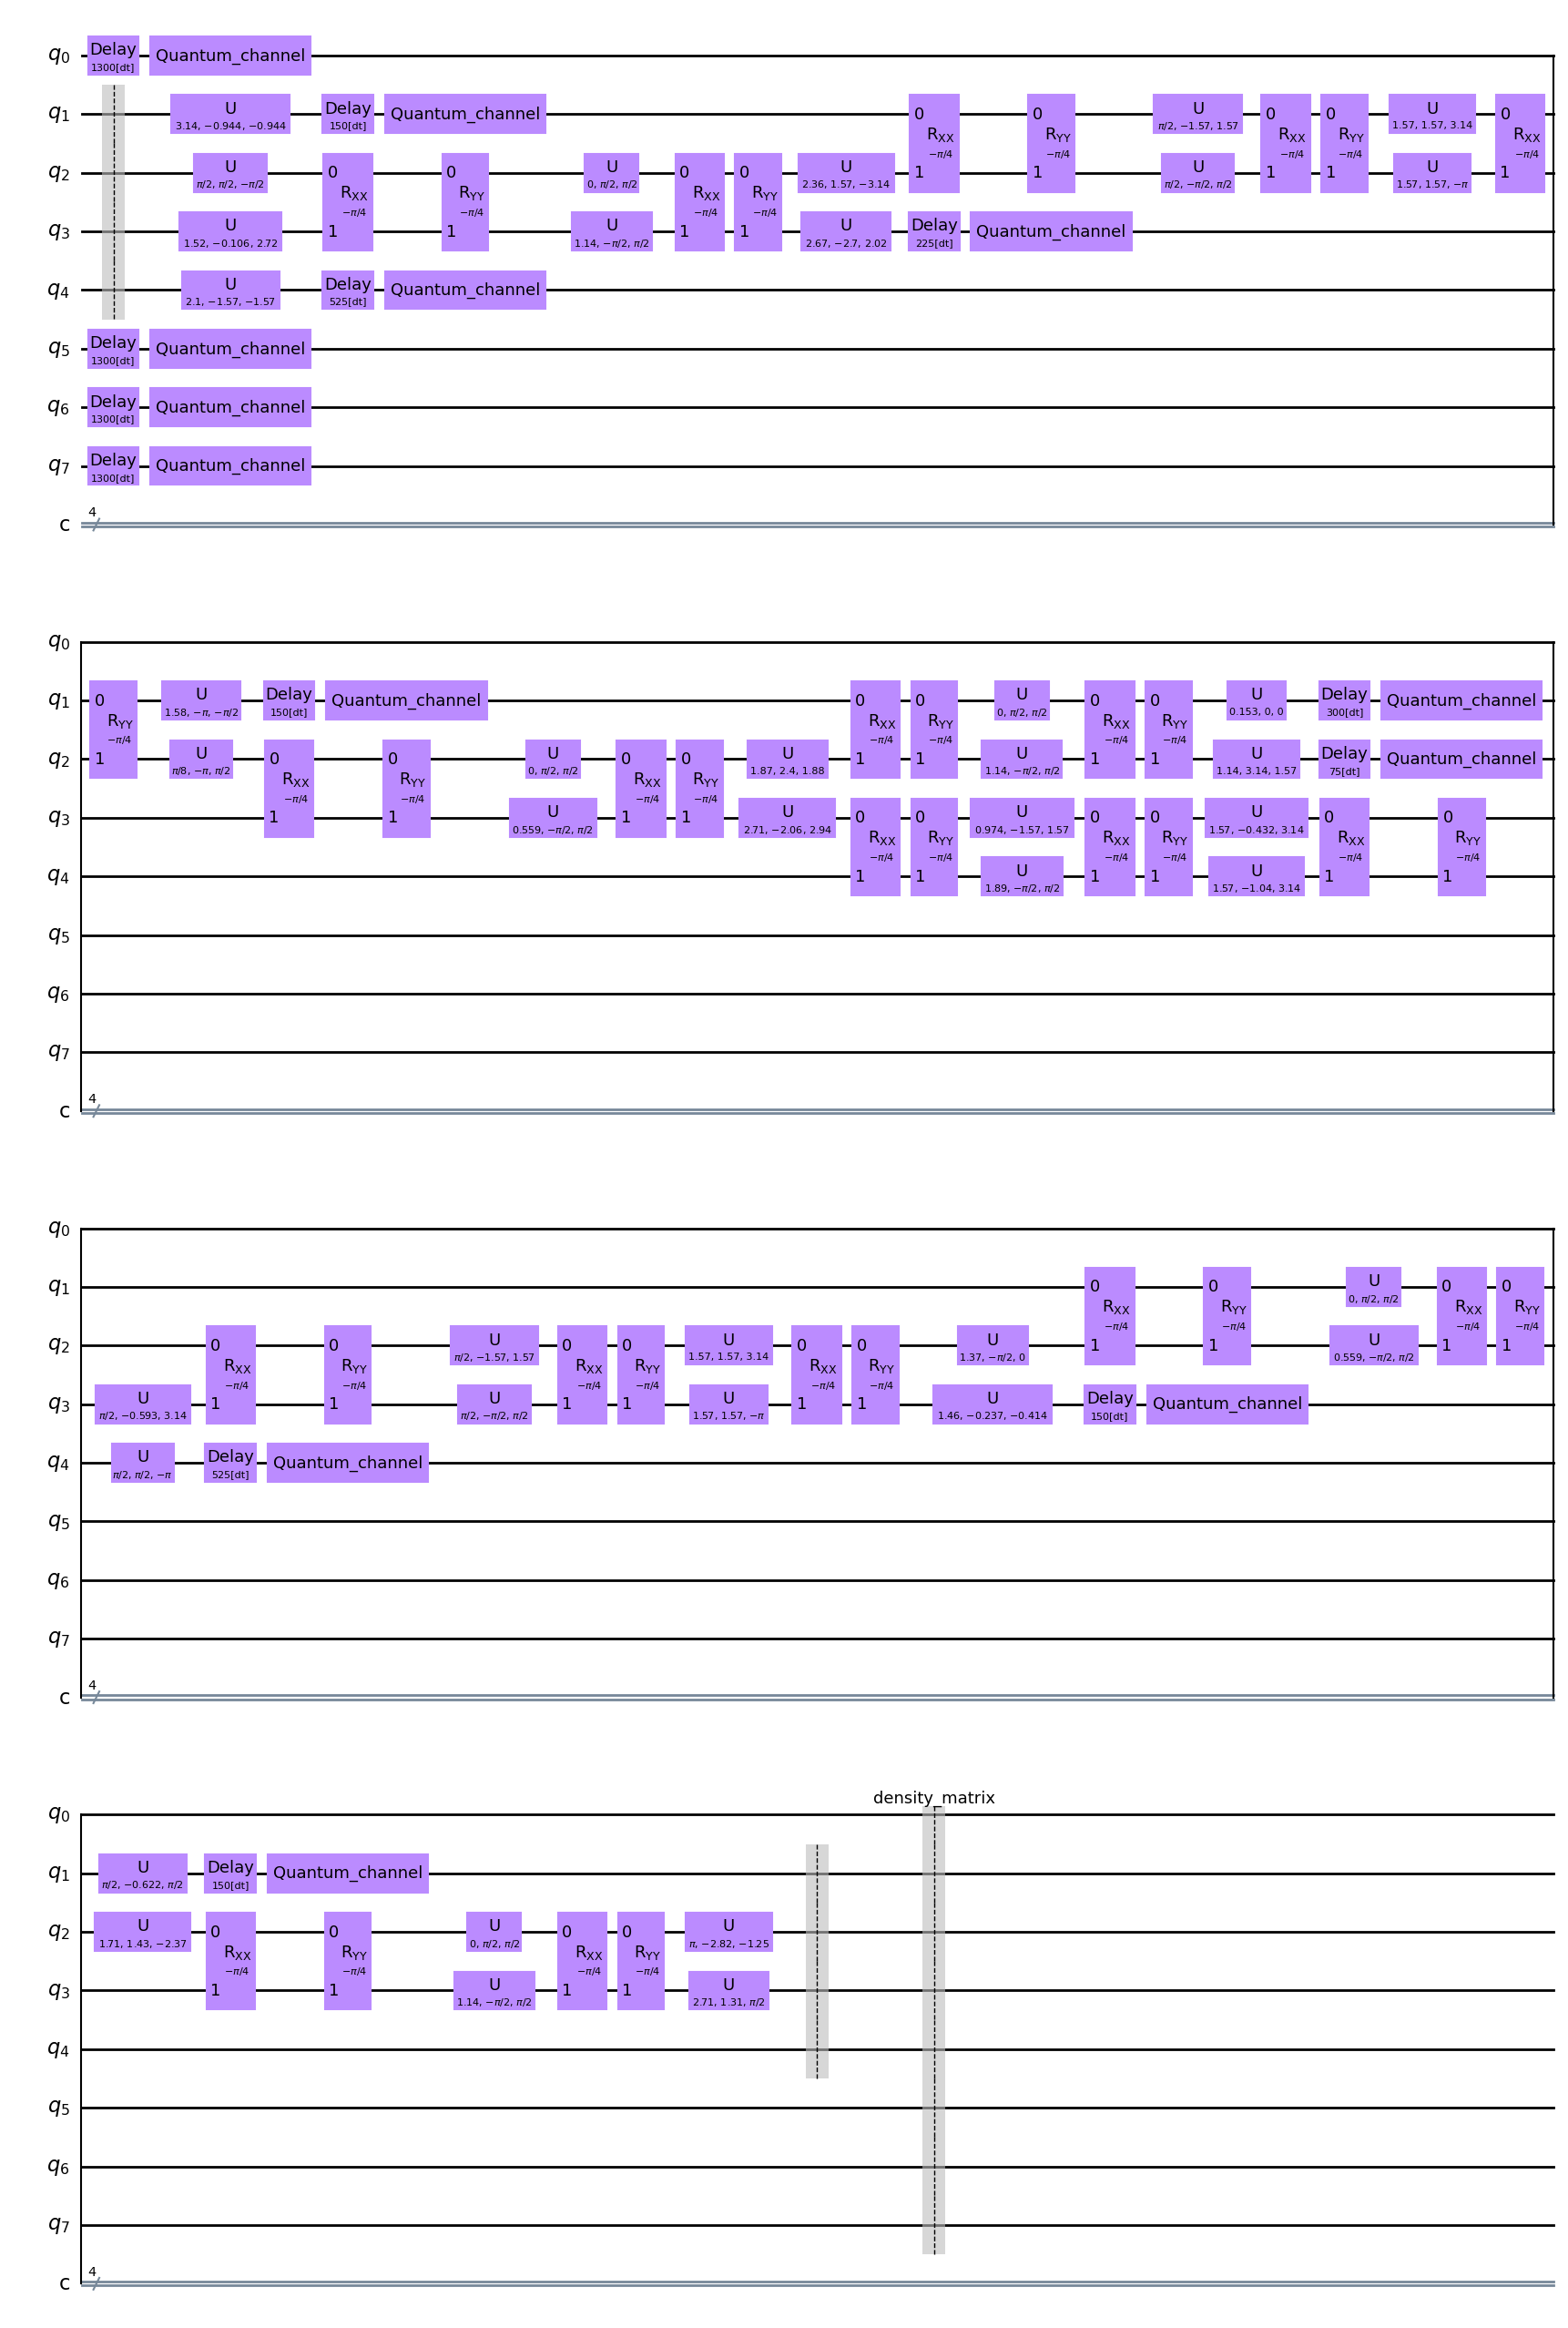

In [107]:
circ.draw("mpl")

In [108]:
from qiskit.quantum_info import state_fidelity

perfect_result = simulator.run(circ).result().data()["density_matrix"]
noisy_result = noisy_simulator.run(circ).result().data()["density_matrix"]
state_fidelity(perfect_result, noisy_result)

0.9906666603534453

In [109]:
0.9913524794833575
0.9906666603534453

0.9913524794833575